## fine-tune SAM (segment anything)

Based on https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb

## Load dataset

In [1]:
from datasets import Dataset, Image

def create_dataset(images, labels):
    print('dataset created')
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    print('casting dataset')
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

In [2]:
import glob
import numpy as np
import re

IMAGE_SIZE=(256, 256)

def dataloader(pathology):
    t = glob.glob('archive/Dataset_BUSI_with_GT/'+pathology+'/*')
    t_mask = glob.glob('archive/Dataset_BUSI_with_GT/'+pathology+'/*mask*')
    t = list(set(t).difference(set(t_mask)))
    t_mask = [i for i in t_mask if 'mask.png' in i]
    t = sorted(t)
    t_mask = sorted(t_mask)
    for i in range(0,133):
        num1= re.search('\(([^)]+)', t[i]).group(1)
        num2= re.search('\(([^)]+)', t_mask[i]).group(1)
        #print(num1,num2)
        assert num1 == num2
    return t,t_mask

#normal,normal_mask=dataloader('normal')
malignant,malignant_mask=dataloader('malignant')
benign,benign_mask=dataloader('benign')

#combined=np.concatenate((normal,malignant,benign))
#combined_mask=np.concatenate((normal_mask,malignant_mask,benign_mask))

combined=np.concatenate((malignant,benign))
combined_mask=np.concatenate((malignant_mask,benign_mask))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(combined, combined_mask, test_size=0.80, random_state=42)

In [3]:
dataset = create_dataset(images=X_train, labels=y_train)
test_dataset = create_dataset(images=X_test, labels=y_test)

dataset created
casting dataset
dataset created
casting dataset


In [4]:
def transforms(examples):
    examples["image"] = [image.convert("RGB").resize((256,256)) for image in examples["image"]]
    examples["label"] = [image.convert("1").resize((256,256)) for image in examples["label"]]
    return examples
dataset = dataset.map(transforms, batched=True)
test = test_dataset.map(transforms, batched=True)

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 129
})

In [6]:
test

Dataset({
    features: ['image', 'label'],
    num_rows: 518
})

We can visualize an example:

In [7]:
example = dataset[0]
image = example["image"]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=1 size=256x256>}

(-0.5, 255.5, 255.5, -0.5)

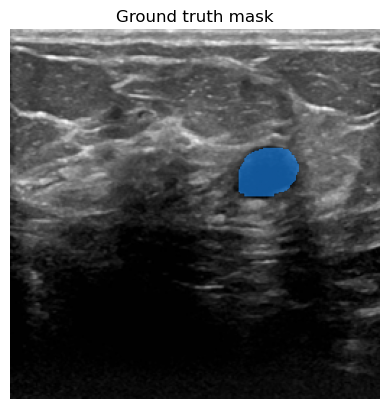

In [8]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

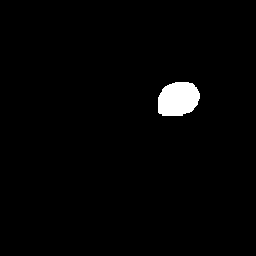

In [9]:
example['label']

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [10]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [11]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [12]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [13]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)
test_dataset = SAMDataset(dataset=test, processor=processor)

In [14]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [17]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Load the model

In [24]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

## Train the model

In [25]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [26]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.27it/s]


EPOCH: 0
Mean loss: 0.22573338196827816


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:31<00:00,  2.08it/s]


EPOCH: 1
Mean loss: 0.16683611124753953


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:31<00:00,  2.08it/s]


EPOCH: 2
Mean loss: 0.15234515959253678


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:30<00:00,  2.12it/s]


EPOCH: 3
Mean loss: 0.14430601293077835


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:30<00:00,  2.16it/s]


EPOCH: 4
Mean loss: 0.13615487968692414


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:30<00:00,  2.14it/s]


EPOCH: 5
Mean loss: 0.13163802789954038


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.25it/s]


EPOCH: 6
Mean loss: 0.12761467242470154


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:30<00:00,  2.16it/s]


EPOCH: 7
Mean loss: 0.12104462110079252


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.18it/s]


EPOCH: 8
Mean loss: 0.11957579518739994


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:27<00:00,  2.35it/s]


EPOCH: 9
Mean loss: 0.11640159161045001


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 10
Mean loss: 0.1106338678071132


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.61it/s]


EPOCH: 11
Mean loss: 0.1137629499229101


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 12
Mean loss: 0.11283452453521582


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 13
Mean loss: 0.10859467427317913


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 14
Mean loss: 0.10466891658993868


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 15
Mean loss: 0.10350684282871393


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 16
Mean loss: 0.10076187252998352


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 17
Mean loss: 0.10157898188783572


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 18
Mean loss: 0.09959160152536173


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.60it/s]


EPOCH: 19
Mean loss: 0.09601345509290696


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 20
Mean loss: 0.09594929969081512


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:25<00:00,  2.51it/s]


EPOCH: 21
Mean loss: 0.09407367895428952


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:26<00:00,  2.44it/s]


EPOCH: 22
Mean loss: 0.09255106317309233


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:26<00:00,  2.45it/s]


EPOCH: 23
Mean loss: 0.09262972411054832


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:26<00:00,  2.43it/s]


EPOCH: 24
Mean loss: 0.0904776408122136


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:26<00:00,  2.43it/s]


EPOCH: 25
Mean loss: 0.09129623209054653


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:26<00:00,  2.43it/s]


EPOCH: 26
Mean loss: 0.09074744513401618


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:26<00:00,  2.45it/s]


EPOCH: 27
Mean loss: 0.09215303315566137


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:29<00:00,  2.21it/s]


EPOCH: 28
Mean loss: 0.09057493719917077


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:27<00:00,  2.37it/s]


EPOCH: 29
Mean loss: 0.08862653443446526


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 30
Mean loss: 0.08581784768746449


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 31
Mean loss: 0.08533546706804862


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 32
Mean loss: 0.08213427531031461


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.62it/s]


EPOCH: 33
Mean loss: 0.08234581420054803


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 34
Mean loss: 0.08788042011169286


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 35
Mean loss: 0.08690663260909227


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 36
Mean loss: 0.08724672886041494


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.62it/s]


EPOCH: 37
Mean loss: 0.0929084141093951


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 38
Mean loss: 0.08222839201872166


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 39
Mean loss: 0.08222961465899761


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 40
Mean loss: 0.08129784143888033


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 41
Mean loss: 0.0817060951430064


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 42
Mean loss: 0.07939619926305917


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 43
Mean loss: 0.07609152215031477


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.63it/s]


EPOCH: 44
Mean loss: 0.07685267948187315


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.62it/s]


EPOCH: 45
Mean loss: 0.07576424542527932


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.62it/s]


EPOCH: 46
Mean loss: 0.07598169245398961


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.62it/s]


EPOCH: 47
Mean loss: 0.07441009575357804


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]


EPOCH: 48
Mean loss: 0.07385246020096999


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.64it/s]

EPOCH: 49
Mean loss: 0.07352051889667144


## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [33]:
def binaryMaskIOU(mask1, mask2):   # From the question.
    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and( mask1==1,  mask2==1 ))
    iou = intersection/(mask1_area+mask2_area-intersection)
    return iou

def map50(iou):
    iou=iou[iou>0.5]
    return np.mean(iou)

## testing dice score

In [35]:
model.eval()
dice_scores=[]
iou_scores=[]
for t in tqdm(test):
    image = t["image"]
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(t["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
    dice_scores.append(dice)
    iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
    iou_scores.append(iou)
np.average(dice_scores), np.average(iou_scores), map50(np.array(iou_scores))

100%|████████████████████████████████████████████████████████████████████████████████| 518/518 [01:40<00:00,  5.14it/s]


(0.897708443458737, 0.8194921581299773, 0.8226687843035916)

**Random test images**

0.8807578371691787 0.7869233901460067
0.9698416394969726 0.9414490787837685
0.93929173693086 0.8855325914149443
0.9235982747997535 0.8580423583285632
0.7339795246634735 0.579753281216381
0.8919688157406261 0.805003350457896
0.9528619528619529 0.909967845659164
0.8974017321785477 0.8138972809667674
0.9175848391361834 0.8477198697068404
0.9177983151012197 0.8480843523978273


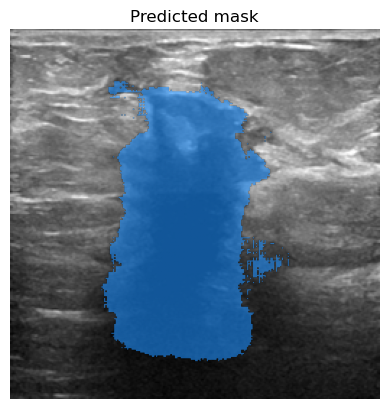

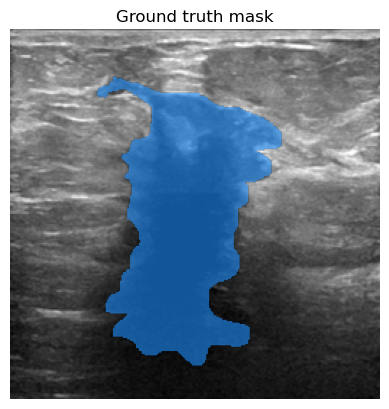

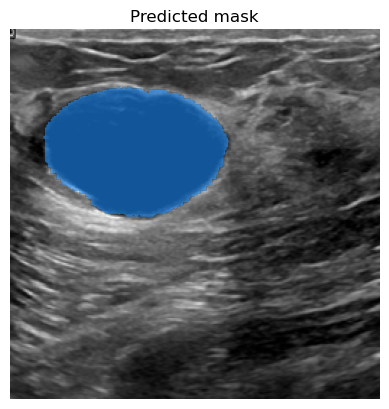

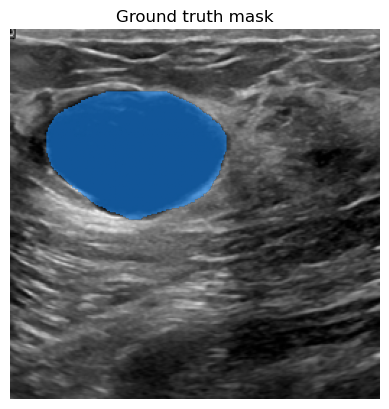

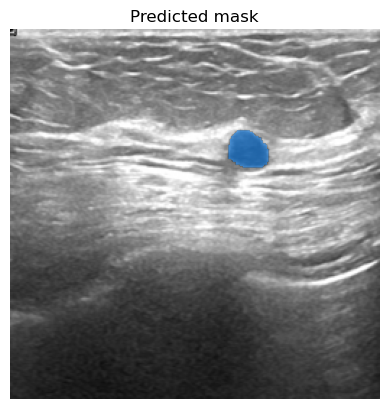

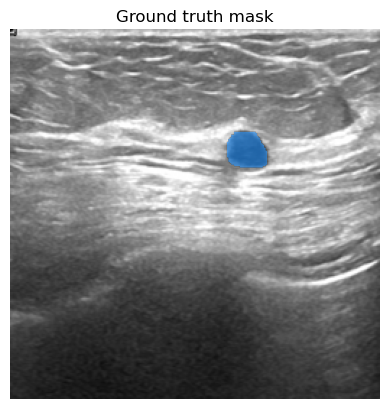

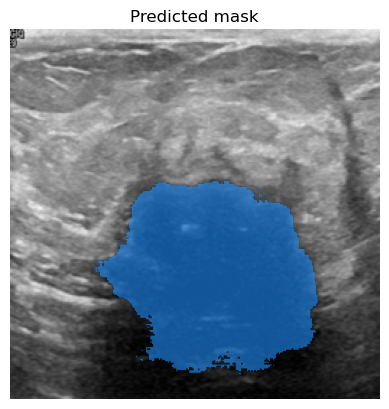

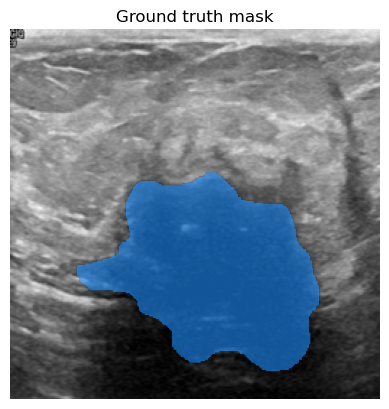

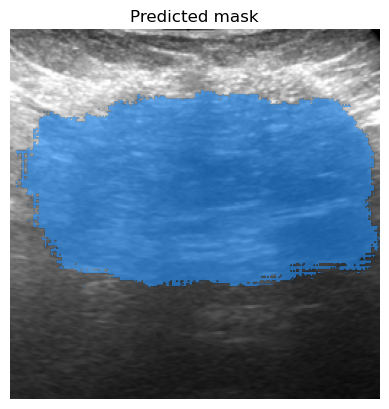

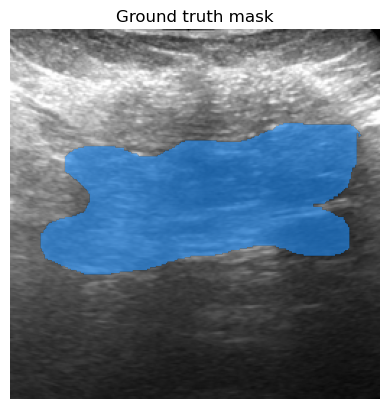

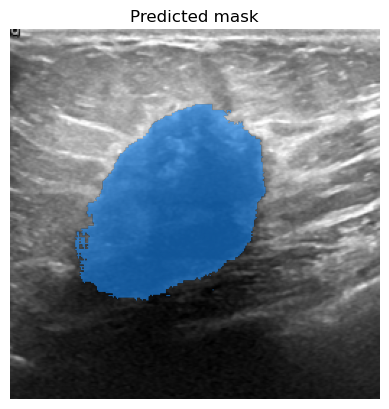

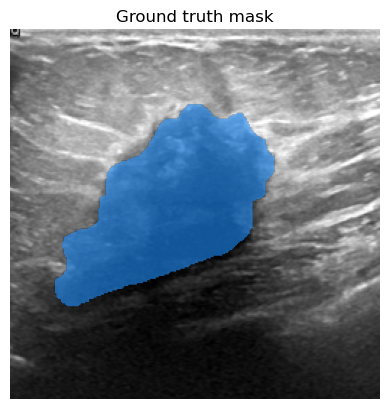

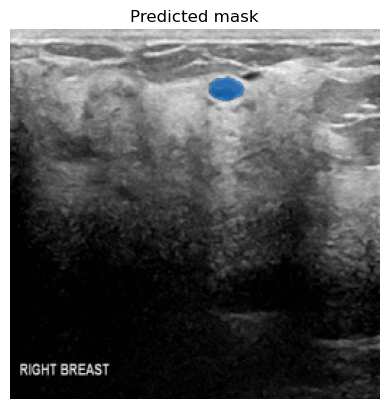

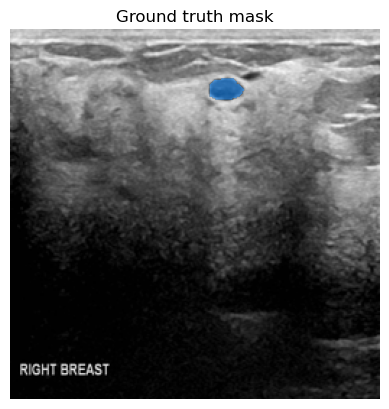

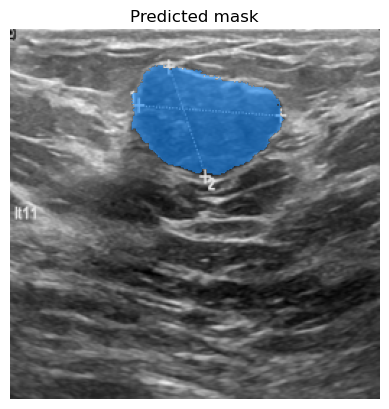

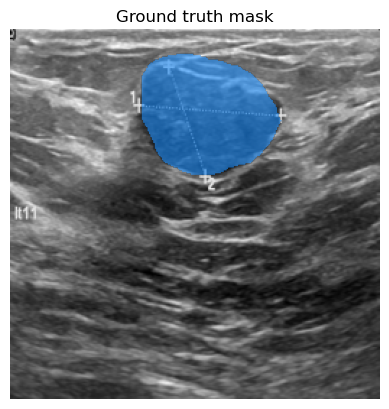

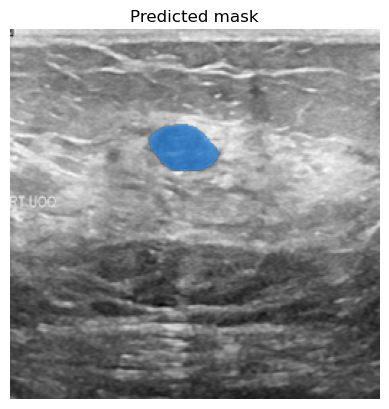

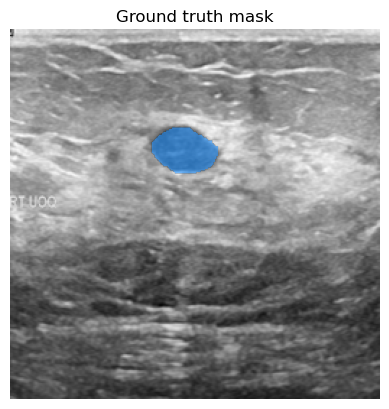

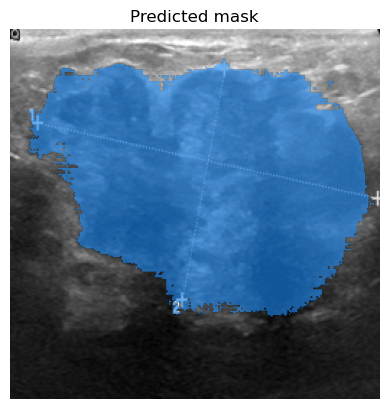

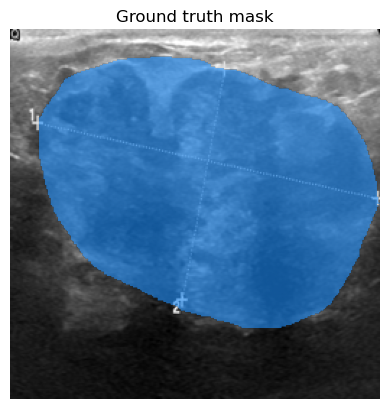

In [74]:
import matplotlib.pyplot as plt

np.random.seed(0)
ran_test=np.random.randint(518, size=10,dtype=np.dtype(int))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
model.eval()
for i in range(10):
    t=test[int(ran_test[i])]
    image = t["image"]
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(t["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    fig, axes = plt.subplots()
    axes.imshow(np.array(image))
    show_mask(medsam_seg, axes)
    axes.title.set_text(f"Predicted mask")
    axes.axis("off")
    
    fig, axes = plt.subplots()

    axes.imshow(np.array(image))
    show_mask(ground_truth_mask, axes)
    axes.title.set_text(f"Ground truth mask")
    axes.axis("off")
    
    dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
    iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
    print(dice, iou)

## training dice score

In [37]:
model.eval()
dice_scores=[]
for t in tqdm(dataset):
    image = t["image"]
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(t["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
    dice_scores.append(dice)
    iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
    iou_scores.append(iou)
np.average(dice_scores), np.average(iou_scores), map50(np.array(iou_scores))

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:24<00:00,  5.29it/s]


(0.9390341183297014, 0.8327097654700205, 0.8353313148986332)

In [23]:
torch.save(model, 'SAM42_50epoch.pth')

## Test on Synthetic Breast Cancer Dataset 

In [49]:
import glob
import numpy as np
import re

IMAGE_SIZE=(256, 256)

def dataloader_test():
    t = glob.glob('archive/BUS Synthetic Dataset/BUS_synthetic_dataset/images/*')
    t_mask = glob.glob('archive/BUS Synthetic Dataset/BUS_synthetic_dataset/masks/*')
    t = sorted(t)
    t_mask = sorted(t_mask)
    print(len(t_mask))
    assert len(t)==len(t_mask)
    for i in range(len(t)):
        num1= int(t[i].split('.')[0].split('\\')[-1])
        num2= int(t_mask[i].split('.')[0].split('\\')[-1])
        #print(num1,num2)
        assert num1 == num2
    return t,t_mask

BUS_test,BUS_test_mask=dataloader_test()

500


In [50]:
from datasets import Dataset, Image

def create_dataset(images, labels):
    print('dataset created')
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    print('casting dataset')
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

BUS_test_dataset = create_dataset(images=BUS_test, labels=BUS_test_mask)

dataset created
casting dataset


In [59]:
def transforms_test(examples):
    examples["image"] = [image.convert("RGB").resize((256,256)) for image in examples["image"]]
    examples["label"] = [image.convert("1").resize((256,256)) for image in examples["label"]]
    return examples
BUS_test_dataset = BUS_test_dataset.map(transforms_test, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [60]:
model.eval()
dice_scores=[]
iou_scores=[]
for t in tqdm(BUS_test_dataset):
    image = t["image"]
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(t["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
    dice_scores.append(dice)
    iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
    iou_scores.append(iou)
np.average(dice_scores), np.average(iou_scores), map50(np.array(iou_scores))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:51<00:00,  4.48it/s]


(0.9218000879423652, 0.8572097137703204, 0.8572097137703204)

In [ ]:
def transforms(examples):
    examples["image"] = [image.convert("RGB").resize((256,256)) for image in examples["image"]]
    examples["label"] = [image.convert("1").resize((256,256)) for image in examples["label"]]
    return examples

0.8976798888057308 0.8143549951503395
0.930825431369501 0.8706019191625473
0.9472438347659055 0.899775148365218
0.8829128267109835 0.7903705707330267
0.9612853500918954 0.9254566210045662
0.9013298067739328 0.8203825063528153
0.8678194267146339 0.7665026650266503
0.8712727272727273 0.7719072164948454
0.8537543492087246 0.744826685815001
0.9589003436426117 0.9210456825983628


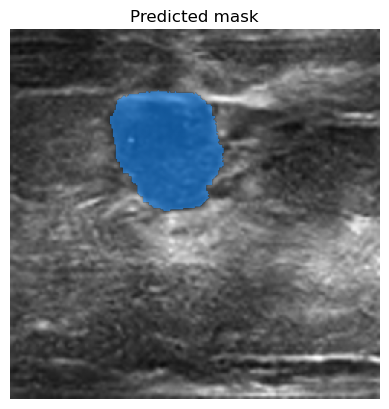

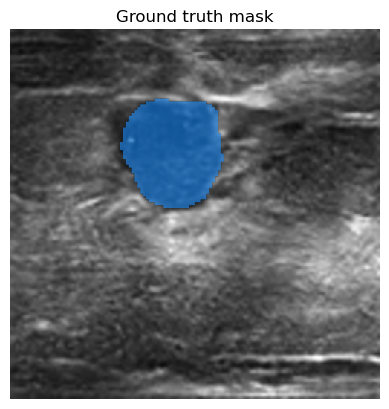

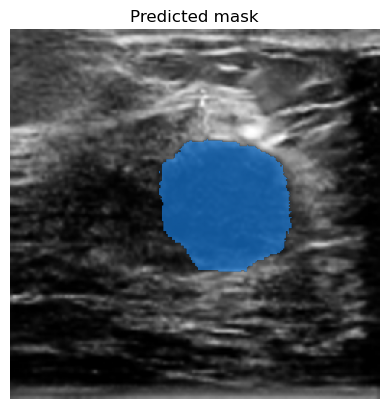

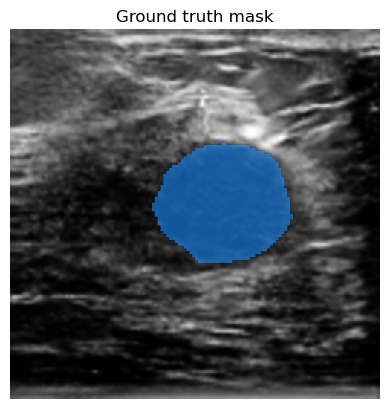

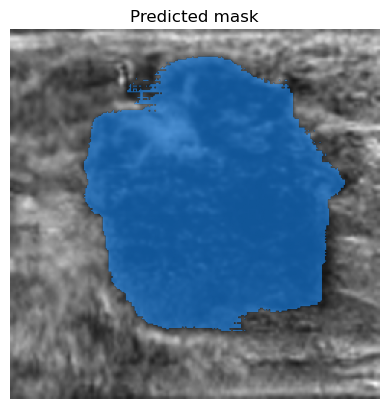

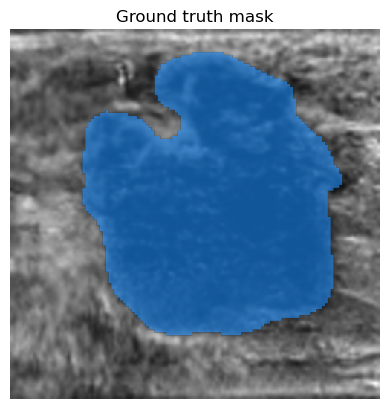

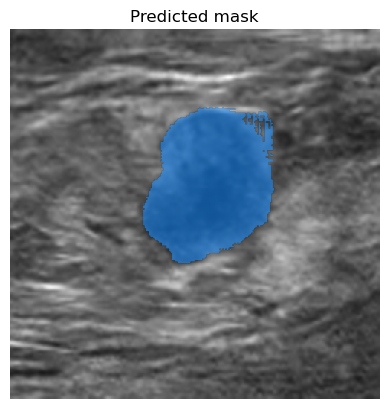

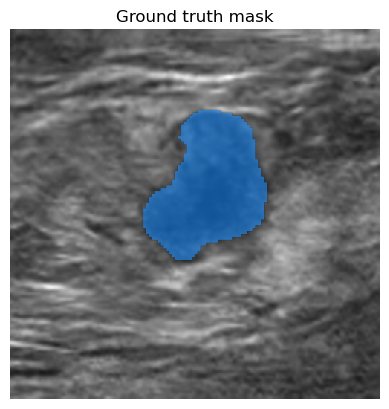

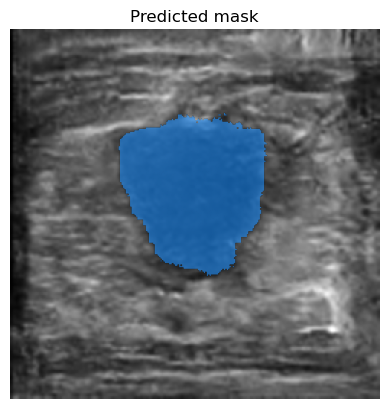

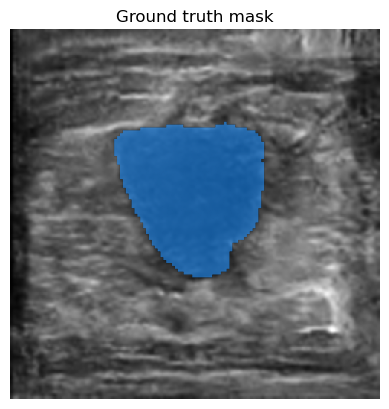

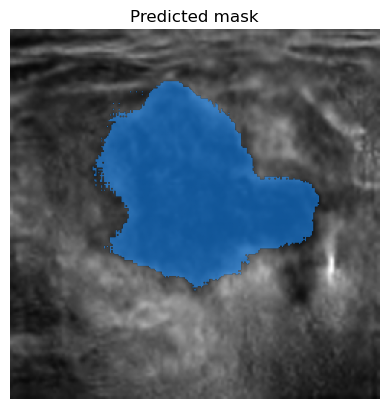

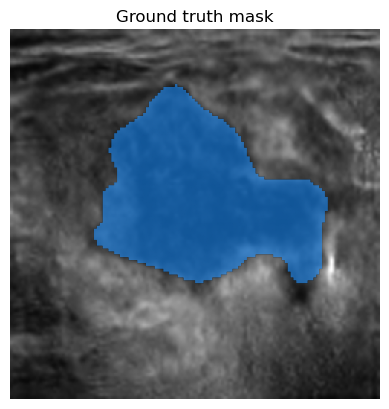

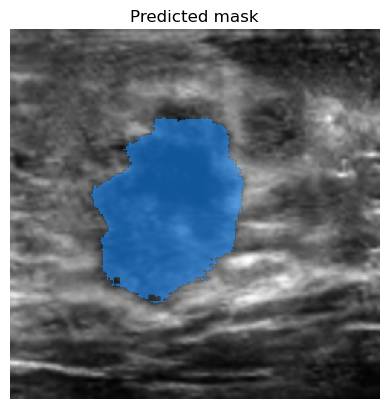

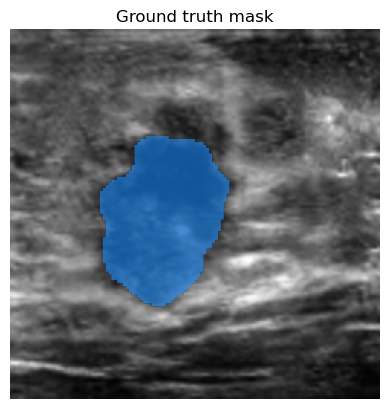

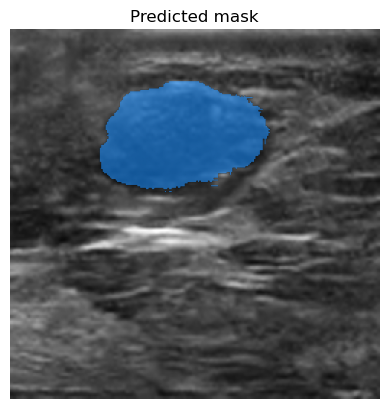

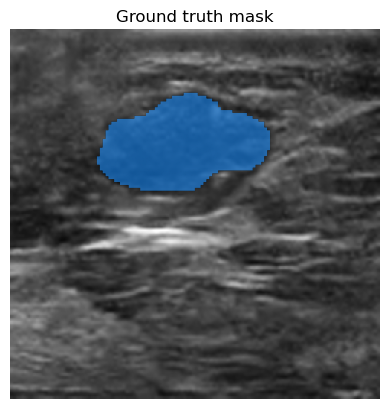

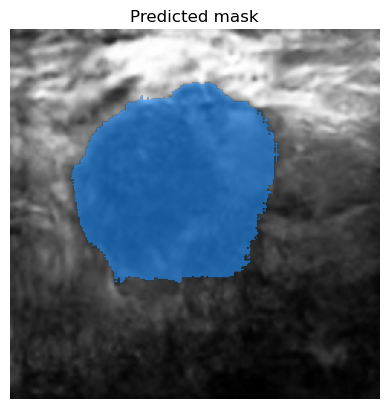

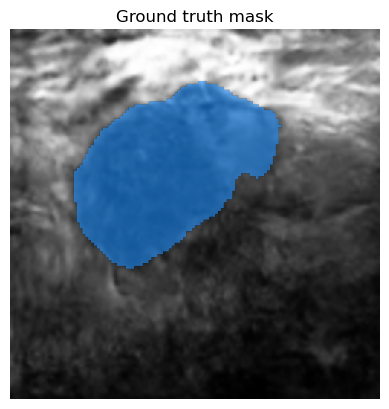

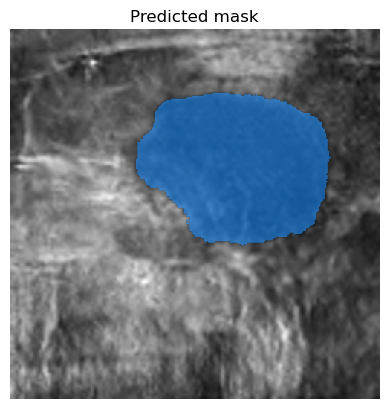

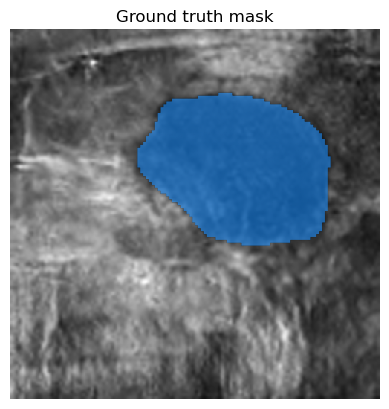

In [75]:
model.eval()
np.random.seed(0)
ran_test=np.random.randint(500, size=10,dtype=np.dtype(int))
for i in ran_test:
    t=BUS_test_dataset[int(i)]
    image = t["image"]
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(t["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    fig, axes = plt.subplots()
    axes.imshow(np.array(image))
    show_mask(medsam_seg, axes)
    axes.title.set_text(f"Predicted mask")
    axes.axis("off")
    
    fig, axes = plt.subplots()

    axes.imshow(np.array(image))
    show_mask(ground_truth_mask, axes)
    axes.title.set_text(f"Ground truth mask")
    axes.axis("off")
    
    dice = np.sum(medsam_seg[ground_truth_mask==1])*2.0 / (np.sum(medsam_seg) + np.sum(ground_truth_mask))
    iou = binaryMaskIOU(medsam_seg,ground_truth_mask)
    print(dice, iou)